### 验证数据集与测试数据集

* 验证数据集：用于模型选择，可以利用该数据集调整模型的超参数
* 测试数据集：只能使用一次的数据集，用于评估模型是否真的很优良
* 小数据集上使用$k$折交叉验证

### 欠拟合与过拟合

* 模型容量：拟合各种函数的能力
    * 低容量的模型难以拟合训练数据
    * 高容量的模型可以记住所有的训练数据
* 模型容量需要匹配数据复杂度，否则可能导致欠拟合和过拟合
* 统计机器学习提供数学工具来衡量模型复杂度
* 实际中一般靠观察训练误差和验证误差

### 现象展示

In [1]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l
import os

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [2]:
# 生成数据集
# 多项式的最大阶数
max_degree = 20
# 训练和测试数据集大小
n_train, n_test = 100, 100
# 分配大量的空间
true_w = np.zeros(max_degree)
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

# 生成一个多项式
features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)  # `gamma(n)` = (n-1)!
# `labels`的维度: (`n_train` + `n_test`,)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

# 转换为tensor
true_w, features, poly_features, labels = [torch.tensor(x, dtype=d2l.float32) for x in
                                           [true_w, features, poly_features, labels]]

In [5]:
# 模型定义
# 损失函数
def evaluate_loss(net, data_iter, loss):
    """评估给定数据集上模型的损失"""
    # metric存储损失的总和,样本数量
    metric = d2l.Accumulator(2)
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]


# 训练函数
def train(train_features, test_features, train_labels, test_labels, num_epochs=400):
    loss = nn.MSELoss()
    input_shape = train_features.shape[-1]
    # 不设置偏置,因为我们已经在多项式特征中实现了它
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1, 1)),
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1, 1)),
                               batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    return net[0].weight.data.numpy()

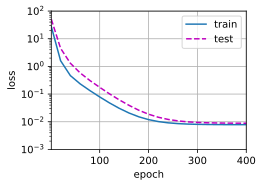

In [9]:
# 正常拟合
normal_res = train(poly_features[:n_train, :4], poly_features[n_train:, :4], labels[:n_train], labels[n_train:])

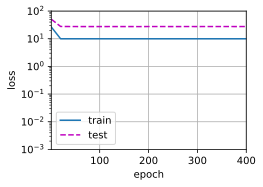

In [10]:
# 欠拟合
under_fit_res = train(poly_features[:n_train, :2], poly_features[n_train:, :2], labels[:n_train], labels[n_train:])

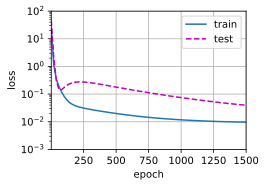

In [11]:
# 过拟合
over_fit_res = train(poly_features[:n_train, :], poly_features[n_train:, :], labels[:n_train], labels[n_train:], num_epochs=1500)